# Import

In [1]:
import csv 
import tensorflow as tf
from numpy import loadtxt
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
import statistics
import copy

# Setting the main model


In [2]:
# Reading the data from csv file
# Columns: Rfloor / Rwalls / Rroof / Rotation / WWR / EUI
dataset=loadtxt('data.csv',delimiter=',')
np.random.shuffle(dataset) 
props=dataset[:,:5]
eui=dataset[:,5:]
props=np.array(props)
eui=np.array(eui)

In [3]:
# Custom metrics
def root_mean_squared_error(y_true, y_pred):
        return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

def abs_max_err(y_true, y_pred):
        return tf.keras.backend.max((tf.keras.backend.abs(y_pred - y_true)))
   

In [ ]:
tf.keras.backend.clear_session()    

bias_init= tf.keras.initializers.Constant(np.mean(eui))

initializer = tf.keras.initializers.GlorotNormal()
    
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 3e-5*(2500-epoch)/2500) 


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(900,kernel_initializer=initializer,input_dim=5
                                ,activity_regularizer=regularizers.l2(2e-5)
                               ))
model.add(tf.keras.layers.Activation('selu'))
model.add(tf.keras.layers.Dense(550,kernel_initializer=initializer))
model.add(tf.keras.layers.Activation('selu'))
model.add(tf.keras.layers.Dense(300,kernel_initializer=initializer,
                                activity_regularizer=regularizers.l2(1e-6)))
model.add(tf.keras.layers.Activation('selu'))
model.add(tf.keras.layers.Dense(128,kernel_initializer=initializer,activation=tf.keras.activations.selu))
model.add(tf.keras.layers.Dense(32,kernel_initializer=initializer,activation=tf.keras.activations.selu))
model.add(tf.keras.layers.Dense(1,use_bias=True, bias_initializer=bias_init))

model.compile(loss = root_mean_squared_error,
              optimizer = optimizer,
             metrics=['mae',abs_max_err,'mse'])

history = model.fit(props,eui, epochs=2250, batch_size=40, 
                    callbacks=[lr_schedule],
                    validation_split=0.0625,
                    verbose=0
                   )

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3.02e-6)

model.compile(loss = root_mean_squared_error,
              optimizer = optimizer,
             metrics=['mae',abs_max_err,'mse'])

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='cp.ckpt',                                                 
                                                 save_weights_only=True,
                                                 verbose=1)
model.fit(props,eui, epochs=1, batch_size=40, 
                    callbacks=[cp_callback],
                    validation_split=0.0625)

243/243 [==============================] - ETA: 0s - loss: 0.5479 - mae: 0.2711 - abs_max_err: 0.9500 - mse: 0.1294
Epoch 00001: saving model to cp.ckpt
243/243 [==============================] - 3s 14ms/step - loss: 0.5479 - mae: 0.2711 - abs_max_err: 0.9500 - mse: 0.1294 - val_loss: 0.7205 - val_mae: 0.3311 - val_abs_max_err: 2.1531 - val_mse: 0.3773


Text(0, 0.5, 'Loss')

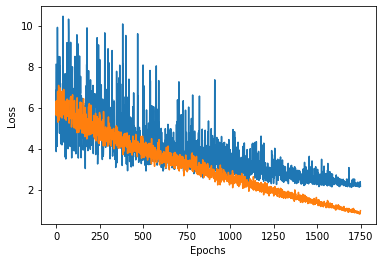

In [14]:
plt.plot(history.history['val_abs_max_err'][500:])
plt.plot(history.history['abs_max_err'][500:])
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [15]:
model.evaluate(props,eui,batch_size=48)

216/216 [==============================] - 1s 5ms/step - loss: 0.4789 - mae: 0.2167 - abs_max_err: 0.8143 - mse: 0.0893


[0.4789418876171112,
 0.2166581153869629,
 0.8143227100372314,
 0.08928953856229782]

Printing model predictions

Text(0, 0.5, 'eui')

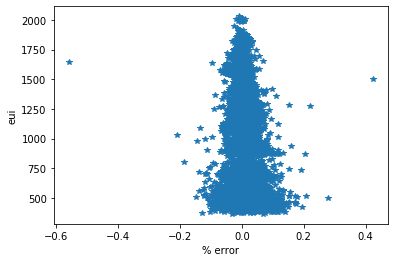

In [17]:
perc=(model.predict(props)-eui)/eui*100
plt.plot(perc[:],eui[:],'*',label='1')
plt.xlabel('% error')
plt.ylabel('eui')


# Load new data

Training/validation split was done manually on a randonly shuffled dataset. The reason is that model.fit(validation_split=x%) takes first x% of the data without shuffling it

In [7]:
# columns: Rfloor / Rwalls / Rroof / Rotation / WWR / EUI
dataset1=loadtxt('data_samevol.csv',delimiter=',')
np.random.shuffle(dataset1) 
tr=int(len(dataset1)*0.0625)
train=dataset1[0:tr,:]
test=dataset1[tr:,:]
train_props=train[:,:5]
train_eui=train[:,5:]
test_props=test[:,:5]
test_eui=test[:,5:]
print(np.mean(train_eui))
print(np.mean(dataset1[:,5:]))

1111.9537037037037
1126.6650752314815


# Quick check that loaded weights give the same result

In [24]:
tf.keras.backend.clear_session()    

bias_init= tf.keras.initializers.Constant(np.mean(train_eui))

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-6)
    
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 3e-5*(550-epoch)/475) 
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(900,kernel_initializer=initializer,input_dim=5
                                ,activity_regularizer=regularizers.l2(2e-5)
                               ))
model.add(tf.keras.layers.Activation('selu'))
model.add(tf.keras.layers.Dense(550,kernel_initializer=initializer))
model.add(tf.keras.layers.Activation('selu'))
model.add(tf.keras.layers.Dense(300,kernel_initializer=initializer,
                                activity_regularizer=regularizers.l2(1e-6)))
model.add(tf.keras.layers.Activation('selu'))
model.add(tf.keras.layers.Dense(128,kernel_initializer=initializer,activation=tf.keras.activations.selu))
model.add(tf.keras.layers.Dense(32,kernel_initializer=initializer,activation=tf.keras.activations.selu))
model.add(tf.keras.layers.Dense(1,use_bias=True, bias_initializer=bias_init))

model.compile(loss = root_mean_squared_error,
              optimizer = optimizer,
             metrics=['mae',abs_max_err,'mse'])

Performance with untrained weights

Text(0, 0.5, 'eui')

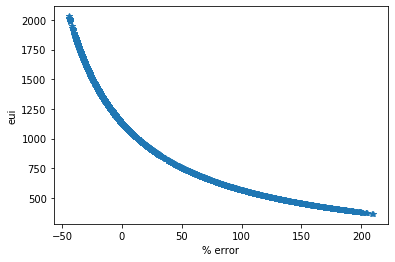

In [25]:
perc=(model.predict(props)-eui)/eui*100
plt.plot(perc[:],eui[:],'*')
plt.xlabel('% error')
plt.ylabel('eui')

In [26]:
model.load_weights('cp.ckpt')

Text(0, 0.5, 'eui')

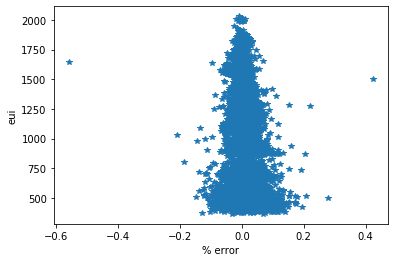

In [27]:
perc=(model.predict(props)-eui)/eui*100
plt.plot(perc[:],eui[:],'*')
plt.xlabel('% error')
plt.ylabel('eui')

Above graph is the same as the first one. Weights were saved and loaded correctly.

# Transfer learning for the second model


Leaving only last 2 layes as trainable to enable transfer learning

In [28]:
layers=['dense','activation', 'dense_1','activation_1','dense_2','activation_2','dense_3']
for i in layers:
    model.get_layer(i).trainable=False

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 900)               5400      
_________________________________________________________________
activation (Activation)      (None, 900)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 550)               495550    
_________________________________________________________________
activation_1 (Activation)    (None, 550)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               165300    
_________________________________________________________________
activation_2 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

Train and save weights:

In [ ]:
history = model.fit(train_props,train_eui, epochs=70, batch_size=24, 
                    #callbacks=[lr_schedule],
                    validation_data=(test_props,test_eui),
                    verbose=0
                   )

In [31]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='cp1.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1)
model.fit(train_props,train_eui, epochs=1, batch_size=24, 
                    callbacks=[cp_callback ],
                    validation_data=(test_props,test_eui))

27/27 [==============================] - ETA: 0s - loss: 0.7135 - mae: 0.4065 - abs_max_err: 1.3078 - mse: 0.2791
Epoch 00001: saving model to cp1.ckpt
27/27 [==============================] - 2s 58ms/step - loss: 0.7135 - mae: 0.4065 - abs_max_err: 1.3078 - mse: 0.2791 - val_loss: 0.9493 - val_mae: 0.5292 - val_abs_max_err: 2.2523 - val_mse: 0.6730


Text(0, 0.5, 'eui')

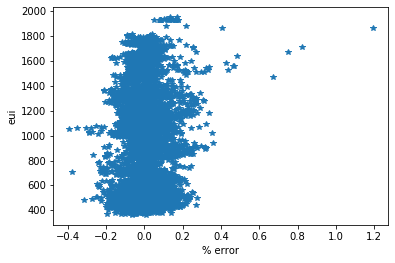

In [32]:
perc=(model.predict(dataset1[:,:5])-dataset1[:,5:])/dataset1[:,5:]*100
plt.plot(perc[:],dataset1[:,5:],'*')
plt.xlabel('% error')
plt.ylabel('eui')

Text(0, 0.5, 'Loss')

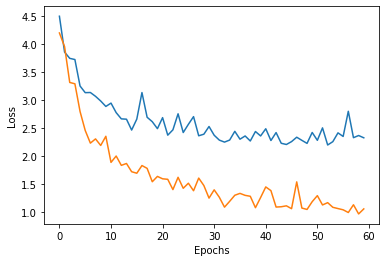

In [33]:
plt.plot(history.history['val_abs_max_err'][10:])
plt.plot(history.history['abs_max_err'][10:])
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Transfer learning for the third model

In [74]:
# columns: Rfloor / Rwalls / Rroof / Rotation / WWR / EUI

dataset2=loadtxt('data_samewall.csv',delimiter=',')
np.random.shuffle(dataset2) 
tr=int(len(dataset2)*0.0625)
train=dataset2[0:tr,:]
test=dataset2[tr:,:]
train_props=train[:,:5]
train_eui=train[:,5:]
test_props=test[:,:5]
test_eui=test[:,5:]
print(np.mean(train_eui))
print(np.mean(dataset2[:,5:]))

1188.2938176197836
1182.058686215877


In [75]:
tf.keras.backend.clear_session()    

bias_init2= tf.keras.initializers.Constant(np.mean(train_eui))

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-6)
    
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 3e-5*(550-epoch)/475) 
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(900,kernel_initializer=initializer,input_dim=5
                                ,activity_regularizer=regularizers.l2(2e-5)
                               ))
model.add(tf.keras.layers.Activation('selu'))
model.add(tf.keras.layers.Dense(550,kernel_initializer=initializer))
model.add(tf.keras.layers.Activation('selu'))
model.add(tf.keras.layers.Dense(300,kernel_initializer=initializer,
                                activity_regularizer=regularizers.l2(1e-6)))
model.add(tf.keras.layers.Activation('selu'))
model.add(tf.keras.layers.Dense(128,kernel_initializer=initializer,activation=tf.keras.activations.selu))
model.add(tf.keras.layers.Dense(32,kernel_initializer=initializer,activation=tf.keras.activations.selu))
model.add(tf.keras.layers.Dense(1,use_bias=True, bias_initializer=bias_init))

model.compile(loss = root_mean_squared_error,
              optimizer = optimizer,
             metrics=['mae',abs_max_err,'mse'])


In [ ]:
model.load_weights('cp.ckpt')

In [77]:
layers=['dense','activation', 'dense_1','activation_1','dense_2','activation_2','dense_3']
for i in layers:
    model.get_layer(i).trainable=False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 900)               5400      
_________________________________________________________________
activation (Activation)      (None, 900)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 550)               495550    
_________________________________________________________________
activation_1 (Activation)    (None, 550)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               165300    
_________________________________________________________________
activation_2 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [ ]:
history = model.fit(train_props,train_eui, epochs=70, batch_size=24, 
                    #callbacks=[lr_schedule],
                    validation_data=(test_props,test_eui),
                    verbose=0
                   )

In [79]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='cp2.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1)
model.fit(train_props,train_eui, epochs=1, batch_size=24, 
                    callbacks=[cp_callback ],
                    validation_data=(test_props,test_eui))

23/27 [========================>.....] - ETA: 0s - loss: 0.5735 - mae: 0.2970 - abs_max_err: 0.9439 - mse: 0.1445
Epoch 00001: saving model to cp2.ckpt
27/27 [==============================] - 2s 59ms/step - loss: 0.5767 - mae: 0.2983 - abs_max_err: 0.9288 - mse: 0.1447 - val_loss: 0.6897 - val_mae: 0.3587 - val_abs_max_err: 1.3856 - val_mse: 0.2657


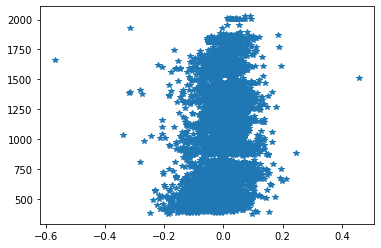

In [80]:
perc=(model.predict(dataset2[:,:5])-dataset2[:,5:])/dataset2[:,5:]*100
plt.plot(perc[:],dataset2[:,5:],'*')

# All models predicted by one net

With aim to demonstrate the effect of transfer learning graphically, we now can use weigths of the third models to predict results of all three models

Text(0, 0.5, 'eui')

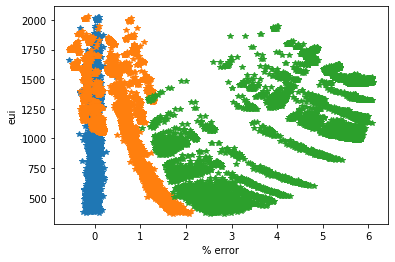

In [83]:
perc=(model.predict(dataset2[:,:5])-dataset2[:,5:])/dataset2[:,5:]*100
plt.plot(perc[:],dataset2[:,5:],'*')
perc1=(model.predict(props)-eui)/eui*100
plt.plot(perc1[:],eui[:],'*')
perc2=(model.predict(dataset1[:,:5])-dataset1[:,5:])/dataset1[:,5:]*100
plt.plot(perc2[:],dataset1[:,5:],'*')
plt.xlabel('% error')
plt.ylabel('eui')

Some values from 'other' models are predicted with a good accuracy due to their similarity

# Now we have weigths that we can use to train an accurate Neural Network for another BIM model to predict its Energy Performance